In [1]:
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
ds_80_sec1_lower=xr.open_dataset('./data/arctic_80.25_sec1_tran_1500_3000.nc')
ds_80_sec2_lower=xr.open_dataset('./data/arctic_80.25_sec2_tran_1500_3500.nc')
ds_80_upper=xr.open_dataset('./data/arctic_80.25_tran_0_1500.nc')

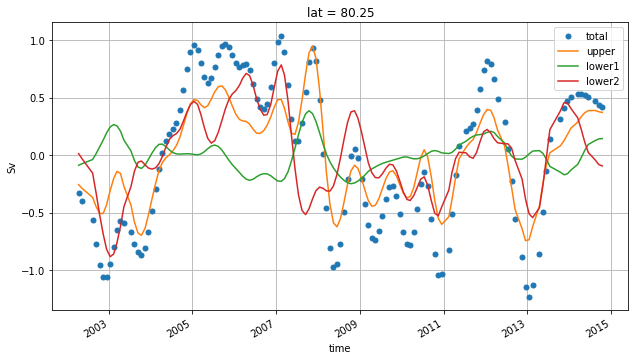

In [6]:
tottran_80=ds_80_upper.meridN_sm_res+ds_80_sec1_lower.meridN_sm_res+ds_80_sec2_lower.meridN_sm_res
fig=plt.figure(figsize=[4,2])
ax1=fig.add_axes([0,0,2,2])
tottran_80.plot(ax=ax1, marker='o', linestyle='none',markersize=5,label='total')
ds_80_upper.meridN_sm_res.plot(ax=ax1,label='upper')
ds_80_sec1_lower.meridN_sm_res.plot(ax=ax1,label='lower1')
ds_80_sec2_lower.meridN_sm_res.plot(ax=ax1,label='lower2')
ax1.set_ylabel('Sv')
ax1.grid()
ax1.legend()

In [4]:
ds_75_sec1_upper=xr.open_dataset('./data/arctic_75.25_sec1_tran_0_1000.nc')
ds_75_sec2_upper=xr.open_dataset('./data/arctic_75.25_sec2_tran_0_600.nc')
ds_75_lower=xr.open_dataset('./data/arctic_75.25_tran_1000_4000.nc')

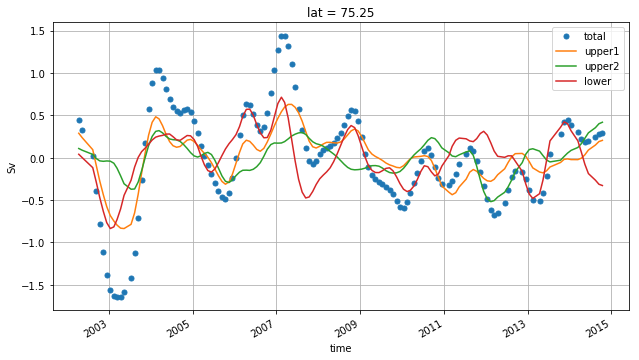

In [5]:
tottran_75=ds_75_sec1_upper.meridN_sm_res+ds_75_sec2_upper.meridN_sm_res+ds_75_lower.meridN_sm_res
fig=plt.figure(figsize=[4,2])
ax1=fig.add_axes([0,0,2,2])
tottran_75.plot(ax=ax1, marker='o', linestyle='none',markersize=5,label='total')
ds_75_sec1_upper.meridN_sm_res.plot(ax=ax1,label='upper1')
ds_75_sec2_upper.meridN_sm_res.plot(ax=ax1,label='upper2')
ds_75_lower.meridN_sm_res.plot(ax=ax1,label='lower')
ax1.set_ylabel('Sv')
ax1.grid()
ax1.legend()

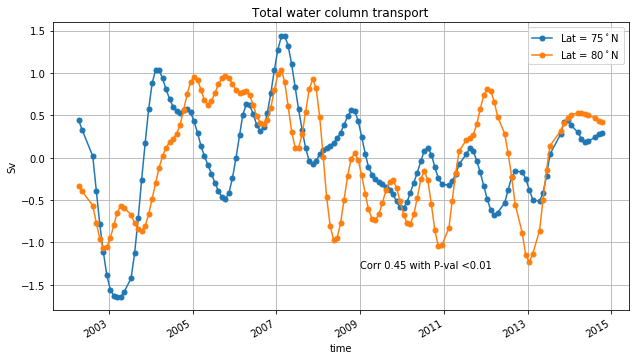

In [25]:
import numpy as np
from scipy.stats.stats import pearsonr
import datetime

r,pval=pearsonr(tottran_75,tottran_80)
fig=plt.figure(figsize=[4,2])
ax1=fig.add_axes([0,0,2,2])
tottran_75.plot(ax=ax1, marker='o', linestyle='solid',markersize=5,label='Lat = 75$^\circ$N')
tottran_80.plot(ax=ax1, marker='o', linestyle='solid',markersize=5,label='Lat = 80$^\circ$N')
ax1.set_ylabel('Sv')
ax1.set_title("Total water column transport")
ax1.grid()
ax1.legend()
ax1.text(datetime.datetime(2009,1,1),-1.3,"Corr %0.2f with P-val <0.01"%(r))

In [24]:
pval

2.1816382022144122e-08